In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "256"

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


In [5]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [6]:
x = False
if len(physical_devices) > 0:
     x = True
x

True

All koden over er for å sjekke og kjøre på GPU

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import pickle
import nibabel as nib


In [8]:

#from monai.apps import DecathlonDataset

from sklearn.model_selection import train_test_split
from fastMONAI.vision_all import *
from PIL import Image 
import PIL 
import numpy.ma as ma
import matplotlib.pyplot as plt
import cv2


<AxesSubplot:>

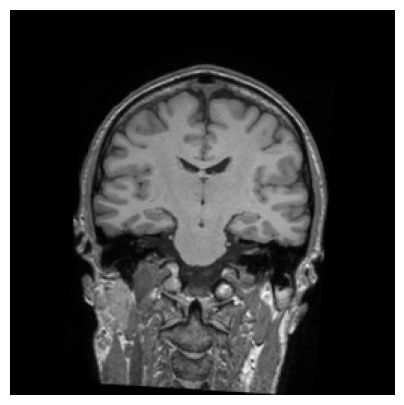

In [9]:
path = Path('../data/processed/IXI_2d_slices/')
fnames = get_image_files(path / "Axial")
masks = get_image_files(path / "AxialMask")

img_fn = fnames[5]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))
#Her henter jeg inn bildene og maskene jeg skal bruke. Viser fram et bilde som eks.

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mask = mpimg.imread(path/'AxialMask/IXI014-HH-1236-2d_axial-mask.png')


plt.imshow(mask, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(mask, cmap='gist_stern')
plt.colorbar()
plt.show()

# Her er eksmepel på maskene med den orginale gråtonen og med colormap gist_stern

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\processed\\IXI_2d_slices\\AxialMask\\IXI012-HH-1211-2d_axial-mask.png'

In [11]:
codes = np.loadtxt(path/'code-kopi_kuttet.txt', dtype=str)
codes

array([['0', 'Unknown', '0', '0', '0', '0\\'],
       ['1', 'Left-Cerebral-Exterior', '70', '130', '180', '0\\'],
       ['2', 'Left-Cerebral-White-Matter', '245', '245', '245', '0\\'],
       ...,
       ['702', 'GrayMatter-FSL-FAST', '205', '62', '78', '0\\'],
       ['703', 'WhiteMatter-FSL-FAST', '0', '225', '0', '0\\'],
       ['999', 'SUSPICIOUS', '255', '100', '100', '0\\']], dtype='<U39')

In [12]:
get_msk = lambda o: path/'AxialMask'/f'{o.stem}-mask{o.suffix}'

In [13]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [14]:
(path/"Axial").ls()[0]

Path('../data/processed/IXI_2d_slices/Axial/.DS_Store')

In [15]:
dls = SegmentationDataLoaders.from_label_func(
     path, bs=2, fnames = fnames, label_func = get_msk, codes = codes, cmap = 'gist_stern'
)

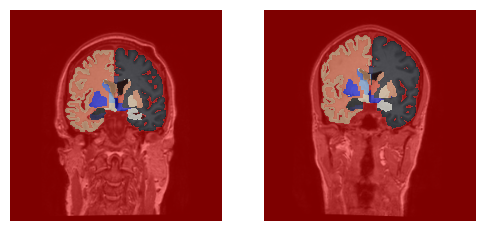

In [16]:
dls.show_batch(max_n=8, cmap = 'flag') #cmap = 'gist_stern'

In [17]:
learn = unet_learner(dls, resnet34)

c:\Users\Bruker\anaconda3\envs\DAT191-gpu_20230411\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bruker\anaconda3\envs\DAT191-gpu_20230411\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
learn.fine_tune(20)

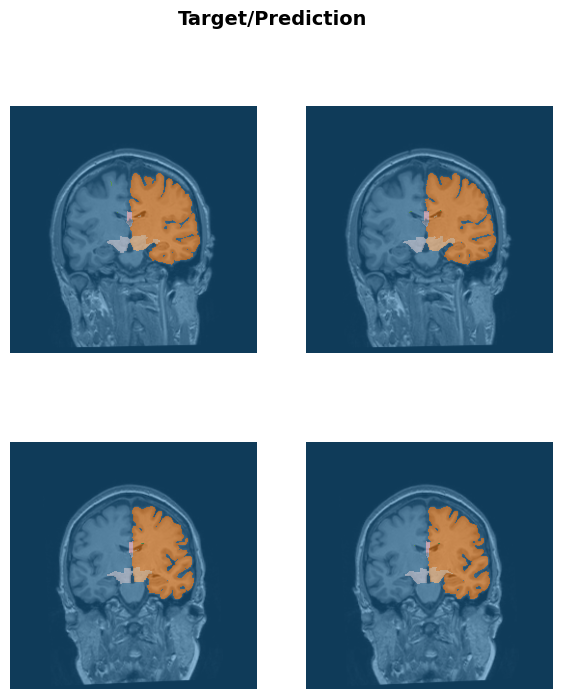

In [24]:
learn.show_results(max_n=2, figsize=(7,8))

In [20]:
learn.summary()

DynamicUnet (Input shape: 2 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 128 x 128  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.0002754228771664202)

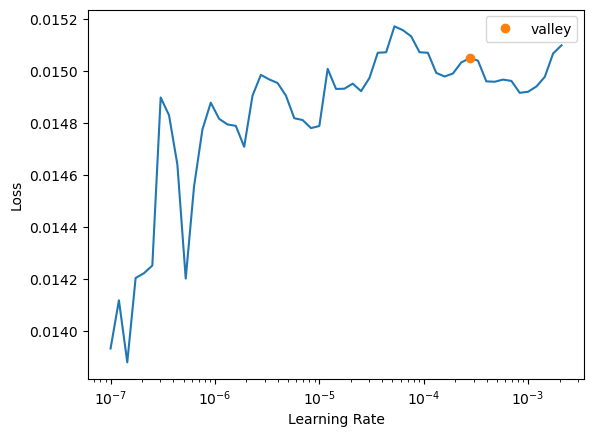

In [21]:
learn.lr_find()

In [22]:
learn.save('stage-1')

Path('../data/processed/IXI_2d_slices/models/stage-1.pth')

In [23]:
learn.load('stage-1')

In [25]:
pickle.dump(learn, open('pickle.pkl', 'wb'))

PicklingError: Can't pickle <function <lambda> at 0x0000016E532F0EE0>: attribute lookup <lambda> on __main__ failed

In [25]:
lr = 1e-4 #(=1^-1 == 0.1)

In [26]:
#learn.fit_flat_cos(10, slice(lr))
learn.fit_flat_cos(5, slice(lr))

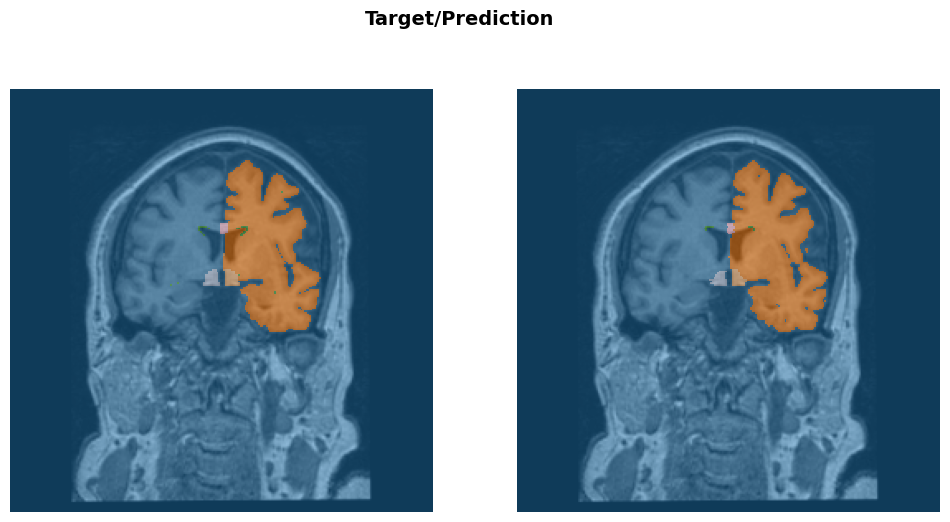

In [23]:
learn.show_results(max_n=4, figsize=(12,6), )

In [ ]:
#plass = "C:\Users\Bruker\Dropbox\BRAINIX-DICOM-T1-IM-0001-0002.nii"
#pred = learn.predict()

<AxesSubplot:>

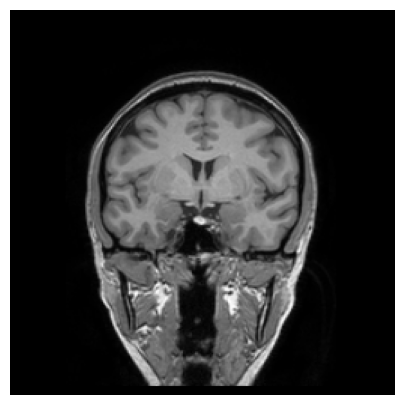

In [26]:
path = Path('../data/processed/IXI_2d_slices/')
test = get_image_files(path / "Test")
test_masks = get_image_files(path / "Test_mask")

test_bilde = test[0]
img = PILImage.create(test_bilde)
img.show(figsize=(5,5))

In [48]:
pred = learn.predict(test[0])
pred

(TensorMask([[0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             ...,
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0]]),
 TensorBase([[0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             ...,
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0],
             [0, 0, 0,  ..., 0, 0, 0]]),
 TensorBase([[[9.9941e-01, 9.9999e-01, 9.9999e-01,  ..., 1.0000e+00,
               9.9998e-01, 9.9755e-01],
              [9.9999e-01, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
               1.0000e+00, 9.9998e-01],
              [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
               1.0000e+00, 9.9999e-01],
              ...,
              [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
               1.0000e+00, 1.0000e+00],
              [1.0000e+00, 1.0000e+00

In [ ]:
import numpy as np
from PIL import Image

# assuming your mask tensor is named `mask_tensor`
mask_np = mask_tensor.cpu().numpy()  # convert tensor to numpy array
mask_np = np.transpose(mask_np, (1, 2, 0))  # transpose array to (height, width, channels)

# assuming you want to save the mask as "mask.png"
mask_image = Image.fromarray(np.uint8(mask_np * 255))  # convert to image and scale to 0-255 range
mask_image.save("mask.png")

In [38]:
import numpy as np
from PIL import Image

# Get the predicted output tensor
predicted_output = pred[2]

# Get the predicted probabilities for the first element in the sequence
predicted_probabilities = predicted_output[0]

# Convert the predicted probabilities to a numpy array and then to a PIL image
predicted_image = Image.fromarray((predicted_probabilities.numpy() * 255).astype(np.uint8))

# Display the PIL image
predicted_image.show()


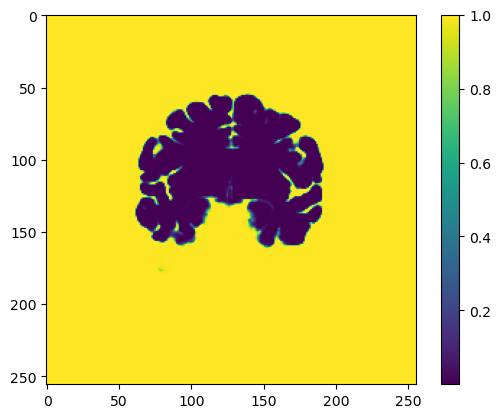

In [35]:

# Get the predicted output tensor
predicted_output = pred[2]

# Get the predicted probabilities for the first element in the sequence
predicted_probabilities = predicted_output[0]

# Display the predicted probabilities as an image
plt.imshow(predicted_probabilities)
plt.colorbar()
plt.show()

<AxesSubplot:>

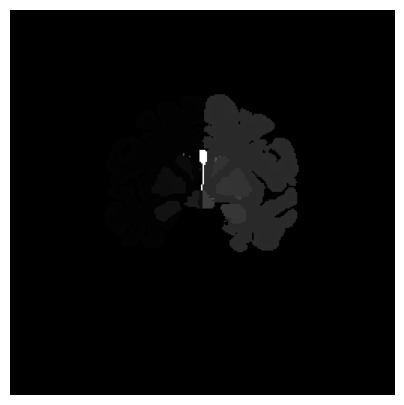

In [29]:
test_label = test_masks[0]
img = PILImage.create(test_label)
img.show(figsize=(5,5))

In [64]:

# Load the target and prediction segmentation maps as grayscale images
target = cv2.imread('../data/processed/IXI_2d_slices/Test_mask/IXI002-Guys-0828-2d_axial-mask.png', cv2.IMREAD_GRAYSCALE)
prediction = pred

# Convert the images to boolean arrays
target_bool = target > 0
prediction_bool = prediction > 0

# Compute the intersection over union score
intersection = np.logical_and(target_bool, prediction_bool)
union = np.logical_or(target_bool, prediction_bool)
iou_score = np.sum(intersection) / np.sum(union)

# Print the IoU score
print("IoU score:", iou_score)

TypeError: '>' not supported between instances of 'tuple' and 'int'

In [ ]:
intersection = np.logical_and(traget, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)

In [66]:
from sklearn.metrics import confusion_matrix
#
preds = learn.get_preds(ds_idx=1, with_decoded=True)[1]

preds_binary = (preds > 0).int()
labeles_binary = (learn.dls.valud_ds[1][1] > 0).int()

preds_flat = np.ravel(preds_binary)
labels_flat = np.ravel(labels_binary)

cm = confusion_matrix(labels_flat, preds_flat)

print(cm)

RuntimeError: Exception occured in `GatherPredsCallback` when calling event `after_batch`:
	[enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 98041856 bytes.